In [1]:
import pickle
import gzip
import numpy as np
import os

In [2]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object


def evaluate(predictions, targets):
    ious = []
    for p, t in zip(predictions, targets):
        assert p['name'] == t['name']
        prediction = np.array(p['prediction'], dtype=bool)
        target = np.array(t['label'], dtype=bool)

        assert target.shape == prediction.shape
        overlap = prediction*target
        union = prediction + target

        ious.append(overlap.sum()/float(union.sum()))
    
    print("Median IOU: ", np.median(ious))

In [3]:
# load data
train_data = load_zipped_pickle("train.pkl")
test_data = load_zipped_pickle("test.pkl")
samples = load_zipped_pickle("sample.pkl")

In [4]:
# make prediction for test
predictions = []
for d in test_data:
    prediction = np.array(np.zeros_like(d['video']), dtype=np.bool)
    height = prediction.shape[0]
    width = prediction.shape[1]
    prediction[int(height/2)-50:int(height/2+50), int(width/2)-50:int(width/2+50)] = True
    
    # DATA Strucure
    predictions.append({
        'name': d['name'],
        'prediction': prediction
        }
    )

In [5]:
train_data[0]["label"][:,:,45].shape


(112, 112)

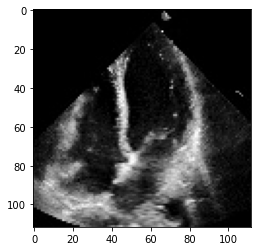

In [6]:
import matplotlib.pyplot as plt 
import numpy as np 
 
X = train_data[0]["video"][:,:,45]
y = train_data[0]["label"][:,:,45]
plt.imshow(X, cmap="gray")
plt.show() 

In [42]:
data = []
import cv2
from skimage.transform import resize

for video in train_data:
    if video["dataset"] == "experta":
        continue
    for fr in video["frames"]:
        if video["video"][:,:,fr].shape != (112,112):
            res = resize(video["video"][:,:,fr], (112, 112))
            res2 = resize(video["label"][:,:,fr], (112, 112))
            store = {}
            store["video"] = res
            store["label"] = res2
        
        else :
            store = {}
            store["video"] = video["video"][:,:,fr]
            store["label"] = video["label"][:,:,fr]
        data.append(store)

X = [im["video"].reshape((112,112,1)) for im in data]
y = [im["label"].reshape((112,112,1)) for im in data]

X = np.reshape(X, (len(X),112,112,1)) 
print(X.shape)
y = np.reshape(y, (len(y),112,112,1)) 
print(y.shape)

(195, 112, 112, 1)
(195, 112, 112, 1)


In [37]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
datagen.fit(X)

In [39]:
len(X)

195

In [40]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def unet(pretrained_weights = None, input_size = (112, 112, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

model = unet()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 112, 112, 1) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 112, 112, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 112, 112, 64) 36928       conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 56, 56, 64)   0           conv2d_25[0][0]                  
____________________________________________________________________________________________

C:\Users\yanis\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [41]:
model.fit(X, y)

7/7 [==============================] - 58s 8s/step - loss: 0.7776 - accuracy: 0.9898


In [54]:
data_test = []
import cv2
from skimage.transform import resize

for video in test_data:
    if video["video"][0].shape != (112,112):
        val = video["video"].shape[-1]
        res = resize(video["video"], (val, 112, 112, 1))
        store = {}
        store["video"] = res
    
    else :
        store = {}
        store["video"] = res
    data_test.append(store)





In [58]:
test_data[0]["video"].shape

(583, 863, 84)

In [60]:
pred = resize(model.predict(data_test[0]["video"]), (583,863,84))

In [84]:
np.where(pred.astype('bool') == True)

(array([  0,   0,   0, ..., 524, 524, 524], dtype=int64),
 array([436, 437, 438, ..., 850, 851, 852], dtype=int64),
 array([79, 79, 79, ..., 82, 82, 82], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

In [63]:
pred[pred < 0.5] = False
pred

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [56]:
y

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 